# SageMaker Batch Transform using an XgBoost Bring Your Own Container (BYOC)

소스 : https://sagemaker-examples.readthedocs.io/en/latest/aws_sagemaker_studio/sagemaker_studio_image_build/xgboost_bring_your_own/Batch_Transform_BYO_XGB.html

이 노트북에서는 Amazon SageMaker Studio를 사용하여 사용자 지정 XGBoost 컨테이너를 구축하는 방법을 보여주는 종단 간 데이터 과학 워크플로를 살펴봅니다. 먼저 SageMaker Processing을 사용하여 데이터를 처리하고, XGB 알고리즘 컨테이너를 ECR로 푸시하고, 모델을 훈련하고, Batch Transform을 사용하여 배치 또는 오프라인 모드에서 모델에서 추론을 생성합니다. 마지막으로 SageMaker Experiments를 사용하여 훈련된 모델과 관련된 메타데이터 및 계보(linenage)를 캡처합니다. 캡처된 메타데이터가 실험 UI에 표시되기 때문에 이것이 SageMaker Studio의 주요 차별화 요소입니다.


## The example

이 예제에서는 UCI 신용 카드 데이터 세트와 함께 작동하는 Python 예제를 사용하여 Amazon SageMaker studio에서 사용자 지정 XGBoost 컨테이너를 패키징하는 방법을 보여줍니다. 다른 알고리즘이나 다른 데이터 세트를 사용하려면 본 예제에 첨부된 Docker 컨테이너와 xgboost 폴더의 변경을 통해 쉽게 준비할 수 있습니다.

이 예에서는 단일 이미지를 사용하여 학습 및 호스팅을 지원합니다. 이렇게 하면 두 작업에 대해 하나의 이미지만 관리하면 되므로 절차가 간소화됩니다. 학습과 호스팅의 요구 사항이 달라서 별도의 이미지가 필요한 경우에는 이를 분리할 수도 있습니다. 이 경우 아래에서 설명되는 Dockerfile을 별도로 분리하고 두 개의 이미지를 빌드합니다. 하나의 이미지를 사용할지 두 개의 이미지를 사용할지 선택하는 것은 어떤 방식이 개발 및 관리하기에 가장 편리한 지에 따라 선택합니다.

교육 또는 호스팅중 하나에만 Amazon SageMaker만 사용하고 둘 다 사용하지 않는 경우에는 해당 기능만 컨테이너에 구축하면 됩니다.

## The workflow

이 노트북은 *데이터 및 기능 엔지니어링 탐색*, *컨티어너 구축*, *컨테이너를 사용하여 모델 학습 및 추론 생성*의 세 부분으로 나뉩니다.

### The Dockerfile

Dockerfile을 통해 빌드하려는 이미지를 정의합니다. 실행하려는 시스템의 전체 운영 체제 설치를 정의하는 것으로 생각할 수 있습니다. 기본 작업을 위해 호스트 시스템의 Linux를 활용하기 때문에 실행 중인 Docker 컨테이너는 전체 운영 체제보다는 훨씬 가볍습니다. 

Python science 스택의 경우, 공식 TensorFlow 도커 이미지에서 시작하여 일반 도구를 실행하고 TensorFlow Serving을 설치합니다. 그런 다음 특정 알고리즘을 구현하는 코드를 컨테이너에 추가하고 이를 실행하기에 적합한 환경을 설정합니다.

BYOC가 SageMaker 노트북 인스턴스와 작동하는 방식에 대한 자세한 내용은 https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionity/scikit_bring_your_own/scikit_bring_your_own.ipynb 예제를 참조하십시오. SageMaker 노트북 인스턴스와 달리 SageMaker 스튜디오에서는 build_and_push.sh 스크립트를 사용하지 않습니다. 대신 studio-build CLI를 이용하여 컨테이너를 ECR로 푸시하는 것을 처리합니다.

이 예제에 대한 Dockerfile을 살펴보겠습니다.

In [2]:
!cat Dockerfile

# Build an image that can do training and inference in SageMaker
# This is a Python 3 image that uses the nginx, gunicorn, flask stack
# for serving inferences in a stable way.

FROM ubuntu:16.04

MAINTAINER Amazon AI <sage-learner@amazon.com>

RUN apt-get update
RUN apt-get install -y software-properties-common
RUN add-apt-repository ppa:deadsnakes/ppa
RUN apt-get update

RUN apt-get install -y build-essential python3.6 python3.6-dev python3-pip python3.6-venv
RUN python3.6 -m pip install pip --upgrade

RUN apt-get -y update && apt-get install -y --no-install-recommends \
         wget \
         nginx \
         libgcc-5-dev \ 
         ca-certificates \
    && rm -rf /var/lib/apt/lists/*

# Here we get all python packages.
# There's substantial overlap between scipy and numpy that we eliminate by
# linking them together. Likewise, pip leaves the install caches populated which uses
# a significant amount of space. These optimizations save a fair amount of space in the
# image, which 

### Step 1: Pre-requisites: Download the necessary libraries

In [3]:
import sys

#!{sys.executable} -m pip install "sagemaker-experiments"
#!{sys.executable} -m pip install "sagemaker-studio-image-build"

In [4]:
!pip install sagemaker-experiments

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


### Step 2: Ensure IAM Role has access to necessary services

SageMaker Studio 이미지 빌드 CLI는 Amazon Elastic Container Registry 및 AWS CodeBuild를 사용하므로 CLI 명령에 대한 입력으로 제공하는 역할에 필요한 정책과 권한이 연결되어 있는지 확인해야 합니다.

Two scenarios are supported including: 
다음과 같은 두 가지 시나리오가 지원됩니다.


* **SageMaker 실행 역할(Execution Role)에 IAM 권한 추가**

   이 시나리오에는 필요한 권한으로 이 노트북 인스턴스에 연결된 실행 역할(Execution Role) 업데이트가 포함됩니다. 이 시나리오에서는 현재 실행 역할을 가져와 신뢰 정책(trush policy) 및 추가 권한이 역할(role)과 연결되어 있는지 확인해야 합니다.
       
* **적절한 권한이 첨부된 별도 역할(role) 생성/활용**

   이 시나리오에는 아래와 같은 권한이 있는 역할(role)을 설정하고 CLI를 호출할 때 --role 인수를 이용하여 실행합니다(예: *sm-docker build . --role build-cli-role*).
   
   
**역할(role)이 다음을 포함하는지 확인합니다.**

1) Trust policy with CodeBuild

      {
      "Version": "2012-10-17",
      "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": [
              "codebuild.amazonaws.com"
            ]
          },
          "Action": "sts:AssumeRole"
        }
      ]
    }
    
2) Permissions attached to the execution role to execute a build in AWS CodeBuild, create ECR repository and push images to ECR 

     {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "codebuild:DeleteProject",
                "codebuild:CreateProject",
                "codebuild:BatchGetBuilds",
                "codebuild:StartBuild"
            ],
            "Resource": "arn:aws:codebuild:*:*:project/sagemaker-studio*"
        },
        {
            "Effect": "Allow",
            "Action": "logs:CreateLogStream",
            "Resource": "arn:aws:logs:*:*:log-group:/aws/codebuild/sagemaker-studio*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "logs:GetLogEvents",
                "logs:PutLogEvents"
            ],
            "Resource": "arn:aws:logs:*:*:log-group:/aws/codebuild/sagemaker-studio*:log-stream:*"
        },
        {
            "Effect": "Allow",
            "Action": "logs:CreateLogGroup",
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "ecr:CreateRepository",
                "ecr:BatchGetImage",
                "ecr:CompleteLayerUpload",
                "ecr:DescribeImages",
                "ecr:DescribeRepositories",
                "ecr:UploadLayerPart",
                "ecr:ListImages",
                "ecr:InitiateLayerUpload",
                "ecr:BatchCheckLayerAvailability",
                "ecr:PutImage"
            ],
            "Resource": "arn:aws:ecr:*:*:repository/sagemaker-studio*"
        },
        {
            "Effect": "Allow",
            "Action": "ecr:GetAuthorizationToken",
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
              "s3:GetObject",
              "s3:DeleteObject",
              "s3:PutObject"
              ],
            "Resource": "arn:aws:s3:::sagemaker-*/*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "s3:CreateBucket"
            ],
            "Resource": "arn:aws:s3:::sagemaker*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "iam:GetRole",
                "iam:ListRoles"
            ],
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": "iam:PassRole",
            "Resource": "arn:aws:iam::*:role/*",
            "Condition": {
                "StringLikeIfExists": {
                    "iam:PassedToService": "codebuild.amazonaws.com"
                }
            }
        }
    ]
}

### Restart Kernel

라이브러리가 설치되면 커널(Kernel) --> 다시시작(Restart)을 클릭하여 커널을 재실행한 후 아래의 모든 셀을 실행합니다.

In [5]:
# Let's inspect the role we have created for our notebook here:
import boto3
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
sess = sagemaker.Session()
region = boto3.session.Session().region_name
print("Region = {}".format(region))
sm = boto3.Session().client("sagemaker")

Region = ap-northeast-1


### Complete Setup: Import libraries and set global definitions.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from time import sleep, gmtime, strftime
import json
import time

In [7]:
# Import SageMaker Experiments

from sagemaker.analytics import ExperimentAnalytics
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

### Specify buckets for storing data

In [8]:
# Use our custom bucket here.
rawbucket = sess.default_bucket()
prefix = "sagemaker-modelmonitor"  # use this prefix to store all files pertaining to this workshop.

dataprefix = prefix + "/data"
traindataprefix = prefix + "/train_data"
testdataprefix = prefix + "/test_data"
testdatanolabelprefix = prefix + "/test_data_no_label"
trainheaderprefix = prefix + "/train_headers"

### Step 3: Data Exploration

데이터 과학 라이프사이클의 핵심은 데이터 탐색(EDA), 전처리(pre-processing) 및 특성 공학(feature engineering)입니다. 데이터 탐색에는 SM 노트북을 사용하고 특성 공학 및 데이터 전처리에는 SM Processing을 사용하겠습니다.

### Download and Import the data

본 노트북에서는 [UCI Machine Learning Archive 데이터 세트 예제](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+client)의 결제 데이터를 사용합니다. 이 예제는 이전 달의 지불 내역, 지불, 청구서 등과 같은 여러 공통 기능이 있어 사용자가 다음 달에 지불을 불이행할지 여부를 이진 분류로 예측합니다.

In [9]:
data = pd.read_excel("data.xls", header=1)
data = data.drop(columns=["ID"])
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [10]:
data.rename(columns={"default payment next month": "Label"}, inplace=True)
lbl = data.Label
data = pd.concat([lbl, data.drop(columns=["Label"])], axis=1)
data.head()

,Label,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,20000,2,2,1,24,2,2,-1,-1,...,689,0,0,0,0,689,0,0,0,0
1,1,120000,2,2,2,26,-1,2,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,0,90000,2,2,2,34,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,0,50000,2,2,1,37,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,0,50000,1,2,1,57,-1,0,-1,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [11]:
COLS = data.columns

### Data Exploration

데이터 세트를 다운로드했으면 데이터 과학 라이프사이클의 다음 단계는 데이터 세트를 탐색하는 것입니다. 상관관계 도표(correlation plot)는 feature들이 상호간 또는 레이블과 연관되어 있는지 여부를 나타낼 수 있습니다.

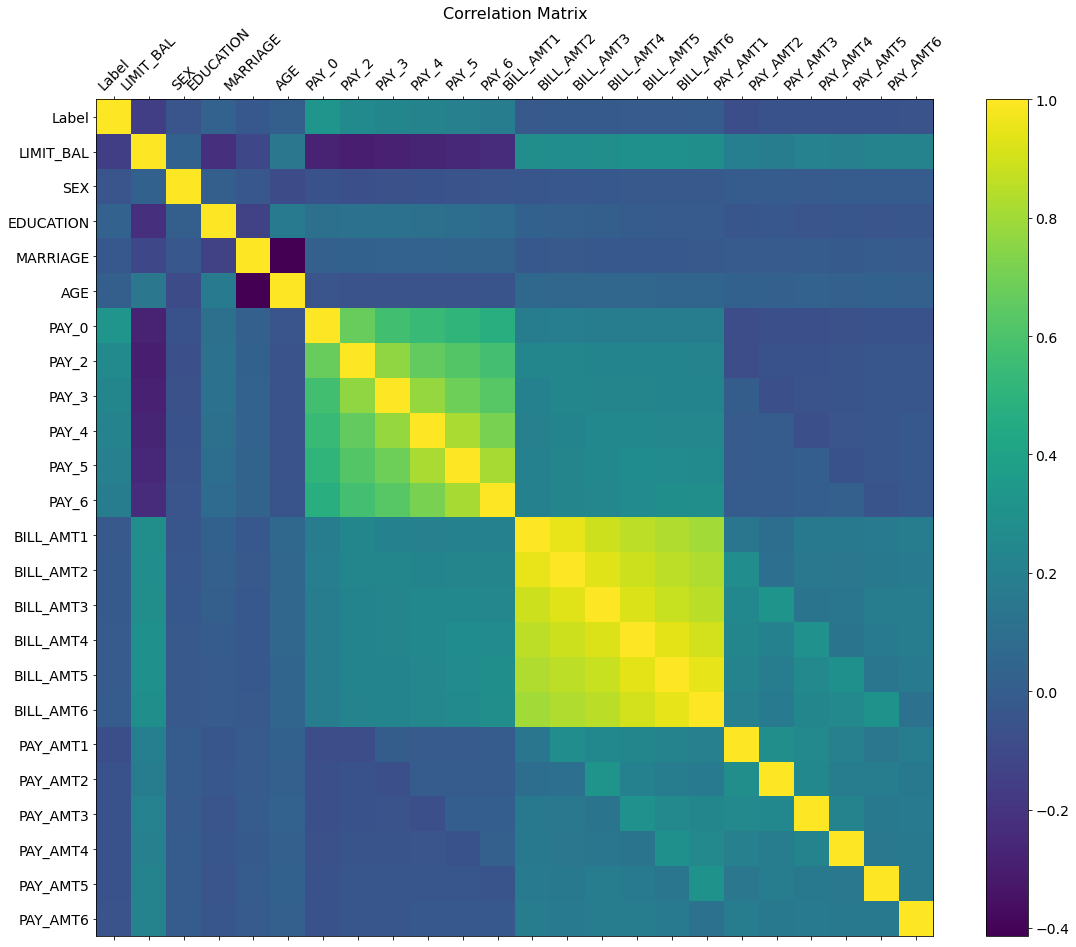

In [12]:
## Corr plot
f = plt.figure(figsize=(19, 15))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=45)
plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Correlation Matrix", fontsize=16);

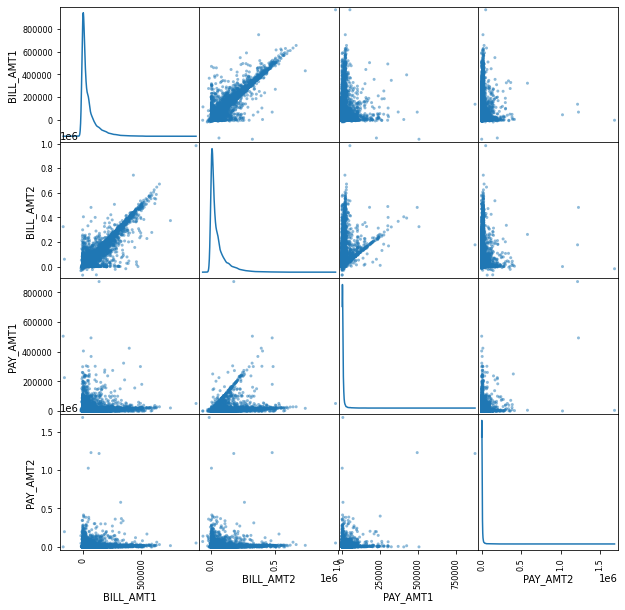

In [13]:
from pandas.plotting import scatter_matrix

SCAT_COLUMNS = ["BILL_AMT1", "BILL_AMT2", "PAY_AMT1", "PAY_AMT2"]
scatter_matrix(data[SCAT_COLUMNS], figsize=(10, 10), diagonal="kde")
plt.show()

### Step 4: Secure Feature Processing pipeline using SageMaker Processing

노트북에서 소량의 데이터를 직접 전처리할 수도 있지만 SageMaker Processing을 이용하면 이를 별도로 분리하여 실행할 수 있습니다. SageMaker Processing을 이용하면 전처리를 위한 별도의 인프라를 프로비저닝하고, S3 위치에서 처리 컨테이너로 데이터를 다운로드하고, 처리 스크립트를 실행하고, Amazon S3의 출력 디렉터리에 처리가 완료된 데이터를 저장한 후 사용한 리소스를 삭제합니다. 처리 작업이 완료되면 작업을 실행하는 데 사용된 인프라와 여기에 저장된 모든 임시 데이터는 제거됩니다.

In [14]:
if not os.path.exists('rawdata/rawdata.csv'):
    !mkdir rawdata
    data.to_csv('rawdata/rawdata.csv', index=None)
else:
    pass

In [15]:
# Upload the raw dataset
raw_data_location = sess.upload_data("rawdata", bucket=rawbucket, key_prefix=dataprefix)
print(raw_data_location)

s3://sagemaker-ap-northeast-1-308961792850/sagemaker-modelmonitor/data


In [16]:
## Use SageMaker Processing with Sk Learn. -- combine data into train and test at this stage if possible.
from sagemaker.sklearn.processing import SKLearnProcessor

sklearn_processor = SKLearnProcessor(
    framework_version="0.20.0", role=role, instance_type="ml.c4.xlarge", instance_count=1
)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


### Write a preprocessing script 

전처리용 코드를 생성합니다.

In [17]:
%%writefile preprocessing.py

import argparse
import os
import warnings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.exceptions import DataConversionWarning
from sklearn.compose import make_column_transformer

warnings.filterwarnings(action="ignore", category=DataConversionWarning)

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--train-test-split-ratio", type=float, default=0.3)
    parser.add_argument("--random-split", type=int, default=0)
    args, _ = parser.parse_known_args()

    print("Received arguments {}".format(args))

    input_data_path = os.path.join("/opt/ml/processing/input", "rawdata.csv")

    print("Reading input data from {}".format(input_data_path))
    df = pd.read_csv(input_data_path)
    df.sample(frac=1)

    COLS = df.columns
    newcolorder = (
        ["PAY_AMT1", "BILL_AMT1"]
        + list(COLS[1:])[:11]
        + list(COLS[1:])[12:17]
        + list(COLS[1:])[18:]
    )

    split_ratio = args.train_test_split_ratio
    random_state = args.random_split

    X_train, X_test, y_train, y_test = train_test_split(
        df.drop("Label", axis=1), df["Label"], test_size=split_ratio, random_state=random_state
    )

    preprocess = make_column_transformer(
        (["PAY_AMT1"], StandardScaler()), (["BILL_AMT1"], MinMaxScaler()), remainder="passthrough"
    )

    print("Running preprocessing and feature engineering transformations")
    train_features = pd.DataFrame(preprocess.fit_transform(X_train), columns=newcolorder)
    test_features = pd.DataFrame(preprocess.transform(X_test), columns=newcolorder)

    # concat to ensure Label column is the first column in dataframe
    train_full = pd.concat(
        [pd.DataFrame(y_train.values, columns=["Label"]), train_features], axis=1
    )
    test_full = pd.concat([pd.DataFrame(y_test.values, columns=["Label"]), test_features], axis=1)

    print("Train data shape after preprocessing: {}".format(train_features.shape))
    print("Test data shape after preprocessing: {}".format(test_features.shape))

    train_features_headers_output_path = os.path.join(
        "/opt/ml/processing/train_headers", "train_data_with_headers.csv"
    )

    train_features_output_path = os.path.join("/opt/ml/processing/train", "train_data.csv")

    test_features_output_path = os.path.join("/opt/ml/processing/test", "test_data.csv")

    print("Saving training features to {}".format(train_features_output_path))
    train_full.to_csv(train_features_output_path, header=False, index=False)
    print("Complete")

    print("Save training data with headers to {}".format(train_features_headers_output_path))
    train_full.to_csv(train_features_headers_output_path, index=False)

    print("Saving test features to {}".format(test_features_output_path))
    test_full.to_csv(test_features_output_path, header=False, index=False)
    print("Complete")

Overwriting preprocessing.py


In [18]:
# Copy the preprocessing code over to the s3 bucket
codeprefix = prefix + "/code"
codeupload = sess.upload_data("preprocessing.py", bucket=rawbucket, key_prefix=codeprefix)
print(codeupload)

s3://sagemaker-ap-northeast-1-308961792850/sagemaker-modelmonitor/code/preprocessing.py


In [19]:
train_data_location = rawbucket + "/" + traindataprefix
test_data_location = rawbucket + "/" + testdataprefix
print("Training data location = {}".format(train_data_location))
print("Test data location = {}".format(test_data_location))

Training data location = sagemaker-ap-northeast-1-308961792850/sagemaker-modelmonitor/train_data
Test data location = sagemaker-ap-northeast-1-308961792850/sagemaker-modelmonitor/test_data


다음으로 관리형 scikit-learn 전처리 컨테이너를 사용하여 위 스크립트를 실행합니다. 이 단계를 실행하는 데 몇 분 정도 걸릴 수 있습니다.

In [20]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

sklearn_processor.run(
    code=codeupload,
    inputs=[ProcessingInput(source=raw_data_location, destination="/opt/ml/processing/input")],
    outputs=[
        ProcessingOutput(
            output_name="train_data",
            source="/opt/ml/processing/train",
            destination="s3://" + train_data_location,
        ),
        ProcessingOutput(
            output_name="test_data",
            source="/opt/ml/processing/test",
            destination="s3://" + test_data_location,
        ),
        ProcessingOutput(
            output_name="train_data_headers",
            source="/opt/ml/processing/train_headers",
            destination="s3://" + rawbucket + "/" + prefix + "/train_headers",
        ),
    ],
    arguments=["--train-test-split-ratio", "0.2"],
)

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

output_config = preprocessing_job_description["ProcessingOutputConfig"]
for output in output_config["Outputs"]:
    if output["OutputName"] == "train_data":
        preprocessed_training_data = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "test_data":
        preprocessed_test_data = output["S3Output"]["S3Uri"]

INFO:sagemaker:Creating processing-job with name sagemaker-scikit-learn-2021-07-13-15-15-13-493



Job Name:  sagemaker-scikit-learn-2021-07-13-15-15-13-493
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-1-308961792850/sagemaker-modelmonitor/data', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-1-308961792850/sagemaker-modelmonitor/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train_data', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-ap-northeast-1-308961792850/sagemaker-modelmonitor/train_data', 'LocalPath': '/opt/ml/processing/train', 'S3UploadMode': 'EndOfJob'}}, {'OutputName': 'test_data', 'AppManaged': False, 'S3Output': {'S

# Part 2: Building the Container and Training the model


### Step 5: Set up SageMaker Experiments

이 노트북에서는 위에서 살펴본 Dockerfile을 이용하여 Docker 이미지를 빌드하고 해당 Dockerfile을 사용하여 모델을 학습합니다.

데이터 과학자를 위해 SageMaker Experiments를 사용하여 원시 데이터 소스에서 전처리 단계 및 모델 교육 파이프라인까지 모델 계보(lineage)를 추적합니다. 데이터 과학자는 SageMaker Experiments를 사용하여 다양한 모델 학습 작업, 데이터 처리 작업, 하이퍼파라미터 조정 작업을 비교, 추적 및 관리하고 원본 데이터에서 학습작업의 결과 생성된 아티팩트, 모델 하이퍼파라미터 및 원하는 사용자 지정 메트릭까지 계보(lineage)를 관리하고 모델 학습의 일부로 모니터링합니다.

In [21]:
# Create a SageMaker Experiment
cc_experiment = Experiment.create(
    experiment_name=f"CreditCardDefault-{int(time.time())}",
    description="Predict credit card default from payments data",
    sagemaker_boto_client=sm,
)
print(cc_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7fe4ddf320f0>,experiment_name='CreditCardDefault-1626189656',description='Predict credit card default from payments data',tags=None,experiment_arn='arn:aws:sagemaker:ap-northeast-1:308961792850:experiment/creditcarddefault-1626189656',response_metadata={'RequestId': '13c99e93-7b58-40da-83e8-8dc7f89b9706', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '13c99e93-7b58-40da-83e8-8dc7f89b9706', 'content-type': 'application/x-amz-json-1.1', 'content-length': '105', 'date': 'Tue, 13 Jul 2021 15:20:56 GMT'}, 'RetryAttempts': 0})


학습 외에도 앞서 실행한 전처리 작업 또한 전체 기계 학습 파이프라인의 계보에 포함하여 추적할 수 있습니다.

In [22]:
# Start Tracking parameters used in the Pre-processing pipeline.
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters({"train_test_split_ratio": 0.2, "random_state": 0})
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="ccdefault-raw-dataset", media_type="s3/uri", value=raw_data_location)
    tracker.log_input(
        name="ccdefault-train-dataset", media_type="s3/uri", value=train_data_location
    )
    tracker.log_input(name="ccdefault-test-dataset", media_type="s3/uri", value=test_data_location)

### Step 6: Build XgBoost container for training

XGB 컨테이너에 대한 코드는 이미 이 노트북과 함께 제공됩니다. 이 컨테이너를 빌드하고 ECR에 푸시하기만 하면 됩니다. 아래 코드 한 줄이면 됩니다.

#### NOTE : SageMaker Studio에서는 아래 코드를 사용합니다.

In [23]:
# !sm-docker build .

#### NOTE : SageMaker 노트북(classic)에서 실행할 경우에는 아래 코드를 이용합니다.

In [24]:
!chmod +x ./build_and_push.sh
!./build_and_push.sh xgboost-byoc

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Sending build context to Docker daemon  10.71MB
Step 1/17 : FROM ubuntu:16.04
 ---> 065cf14a189c
Step 2/17 : MAINTAINER Amazon AI <sage-learner@amazon.com>
 ---> Using cache
 ---> 744aab8bea92
Step 3/17 : RUN apt-get update
 ---> Using cache
 ---> e9697300fe81
Step 4/17 : RUN apt-get install -y software-properties-common
 ---> Using cache
 ---> 8ec16195ded6
Step 5/17 : RUN add-apt-repository ppa:deadsnakes/ppa
 ---> Using cache
 ---> 9acdee2954e5
Step 6/17 : RUN apt-get update
 ---> Using cache
 ---> 18e1e9b390d7
Step 7/17 : RUN apt-get install -y build-essential python3.6 python3.6-dev python3-pip python3.6-venv
 ---> Using cache
 ---> dad321293eea
Step 8/17 : RUN python3.6 -m pip install pip --upgrade
 ---> Using cache
 ---> b3f0eb649938
Step 9/1

### Step 7: Train the Model

이전단계의 SM Processing 에 적용한 것과 동일한 보안 설정이 학습 작업에도 적용됩니다. 또한 SageMaker Experiment를 통해 학습 작업을 추적하고 모델 아티팩트 위치, 훈련/검증 데이터 위치, 모델 하이퍼파라미터 등과 같은 메타데이터를 저장하도록 합니다.

위에 표시된 것처럼 이미지 URI의 형식은 다음과 같습니다.  
- 이미지 URI: {account-id}.dkr.ecr.{region}.amazonaws.com/sagemaker-studio-{studioID}:{username}

SageMaker 노트북 classic을 사용하는 경우 이미지 URI는 다음과 같습니다.
- 이미지 URI: {account-id}.dkr.ecr.{region}.amazonaws.com/{image_name_that_you_defined}:latest

#### NOTE : SageMaker studio에서는 아래 셀의 코드를 이용합니다.

In [25]:
# account = sess.boto_session.client("sts").get_caller_identity()["Account"]
# ecr = boto3.client("ecr")
# domain_id = "sagemaker-studio-{}".format(sm.list_apps()["Apps"][0]["DomainId"])
# image_tag = ecr.list_images(repositoryName=domain_id, filter={"tagStatus": "TAGGED"})["imageIds"][
#     0
# ]["imageTag"]
# image = "{}.dkr.ecr.{}.amazonaws.com/{}:{}".format(account, region, domain_id, image_tag)
# preprocessing_trial_component = tracker.trial_component

# trial_name = f"cc-fraud-training-job-{int(time.time())}"
# cc_trial = Trial.create(
#     trial_name=trial_name, experiment_name=cc_experiment.experiment_name, sagemaker_boto_client=sm
# )

# cc_trial.add_trial_component(preprocessing_trial_component)
# cc_training_job_name = "cc-training-job-{}".format(int(time.time()))

#### NOTE : SageMaker 노트북 classic을 사용하는 경우 아래 셀의 코드를 이용합니다.

In [27]:
account = sess.boto_session.client("sts").get_caller_identity()["Account"]

image = "{}.dkr.ecr.{}.amazonaws.com/{}:{}".format(account, region, 'xgboost-byoc', 'latest')
preprocessing_trial_component = tracker.trial_component
trial_name = f"cc-fraud-training-job-{int(time.time())}"
cc_trial = Trial.create(
    trial_name=trial_name, experiment_name=cc_experiment.experiment_name, sagemaker_boto_client=sm
)

cc_trial.add_trial_component(preprocessing_trial_component)
cc_training_job_name = "cc-training-job-{}".format(int(time.time()))

#### 이제 Estmiator를 선언하고 학습을 시작합니다.

In [28]:
xgb = sagemaker.estimator.Estimator(
    image,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    max_run=86400,
    output_path="s3://{}/{}/models".format(rawbucket, prefix),
    sagemaker_session=sess,
)  # set to true for distributed training

xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    verbosity=0,
    objective="binary:logistic",
    num_round=100,
)

xgb.fit(
    inputs={"training": "s3://" + train_data_location},
    job_name=cc_training_job_name,
    experiment_config={
        "TrialName": cc_trial.trial_name,  # log training job in Trials for lineage
        "TrialComponentDisplayName": "Training",
    },
    wait=True,
)
time.sleep(2)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: cc-training-job-1626189823


2021-07-13 15:23:45 Starting - Starting the training job...
2021-07-13 15:23:46 Starting - Launching requested ML instancesProfilerReport-1626189824: InProgress
......
2021-07-13 15:25:12 Starting - Preparing the instances for training......
2021-07-13 15:26:16 Downloading - Downloading input data
2021-07-13 15:26:16 Training - Downloading the training image......
2021-07-13 15:27:13 Training - Training image download completed. Training in progress..[2021-07-13 15:27:10.519 ip-10-0-118-207.ap-northeast-1.compute.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
Libraries imported
Starting the training.
Training complete.

2021-07-13 15:27:33 Uploading - Uploading generated training model
2021-07-13 15:27:33 Completed - Training job completed
Training seconds: 77
Billable seconds: 77


SageMaker Experiments를 사용하여 학습작업을 추적하면 모델의 메타데이터를 추출하여 소스 데이터, 모델 아티팩트, 하이퍼파라미터 등 모델의 전체 계보를 얻을 수 있습니다.

Experiments의 추적 실행은 **describe_trial_component** API를 호출합니다.

In [29]:
# Present the Model Lineage as a dataframe
from sagemaker.session import Session

session = boto3.Session()
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(session, sm),
    search_expression={
        "Filters": [{"Name": "Parents.TrialName", "Operator": "Equals", "Value": trial_name}]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)
lineagedf = lineage_table.dataframe()

lineagedf

,TrialComponentName,DisplayName,random_state,train_test_split_ratio,ccdefault-raw-dataset - MediaType,ccdefault-raw-dataset - Value,ccdefault-test-dataset - MediaType,ccdefault-test-dataset - Value,ccdefault-train-dataset - MediaType,ccdefault-train-dataset - Value,...,max_depth,min_child_weight,num_round,objective,subsample,verbosity,training - MediaType,training - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value
0,TrialComponent-2021-07-13-152056-lvjp,Preprocessing,0.0,0.2,s3/uri,s3://sagemaker-ap-northeast-1-308961792850/sag...,s3/uri,sagemaker-ap-northeast-1-308961792850/sagemake...,s3/uri,sagemaker-ap-northeast-1-308961792850/sagemake...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cc-training-job-1626189823-aws-training-job,Training,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,6.0,100.0,binary:logistic,0.8,0.0,NaN,s3://sagemaker-ap-northeast-1-308961792850/sag...,NaN,s3://sagemaker-ap-northeast-1-308961792850/sag...


In [30]:
# get detailed information about a particular trial
sm.describe_trial_component(TrialComponentName=lineagedf.TrialComponentName[1])

{'TrialComponentName': 'cc-training-job-1626189823-aws-training-job',
 'TrialComponentArn': 'arn:aws:sagemaker:ap-northeast-1:308961792850:experiment-trial-component/cc-training-job-1626189823-aws-training-job',
 'DisplayName': 'Training',
 'Source': {'SourceArn': 'arn:aws:sagemaker:ap-northeast-1:308961792850:training-job/cc-training-job-1626189823',
  'SourceType': 'SageMakerTrainingJob'},
 'Status': {'PrimaryStatus': 'Completed',
  'Message': 'Status: Completed, secondary status: Completed, failure reason: .'},
 'StartTime': datetime.datetime(2021, 7, 13, 15, 26, 10, tzinfo=tzlocal()),
 'EndTime': datetime.datetime(2021, 7, 13, 15, 27, 27, tzinfo=tzlocal()),
 'CreationTime': datetime.datetime(2021, 7, 13, 15, 23, 45, 571000, tzinfo=tzlocal()),
 'CreatedBy': {},
 'LastModifiedTime': datetime.datetime(2021, 7, 13, 15, 27, 54, 544000, tzinfo=tzlocal()),
 'LastModifiedBy': {},
 'Parameters': {'SageMaker.ImageUri': {'StringValue': '308961792850.dkr.ecr.ap-northeast-1.amazonaws.com/xgboos

# Part 3: Using the trained model for inference

### Step 8: Inference using Batch Transform

먼저 Batch Transform을 사용하여 이전에 사전 처리한 테스트 데이터 세트에 대한 추론을 생성해 보겠습니다.

In [31]:
s3 = boto3.client("s3")
s3.download_file(rawbucket, testdataprefix + "/test_data.csv", "test_data.csv")

In [32]:
newcolorder = (
    ["PAY_AMT1", "BILL_AMT1"] + list(COLS[1:])[:11] + list(COLS[1:])[12:17] + list(COLS[1:])[18:]
)
test_full = pd.read_csv("test_data.csv", names=["Label"] + newcolorder)
test_full.head()

,Label,PAY_AMT1,BILL_AMT1,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,...,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0,-0.341476,0.201175,20000.0,1.0,1.0,2.0,33.0,1.0,2.0,...,17399.0,19057.0,18453.0,19755.0,19288.0,2260.0,0.0,1600.0,0.0,644.0
1,0,-0.136859,0.199594,20000.0,2.0,2.0,2.0,35.0,0.0,0.0,...,19347.0,18600.0,19000.0,19000.0,20000.0,0.0,1000.0,0.0,1000.0,0.0
2,0,-0.284364,0.185736,230000.0,2.0,1.0,1.0,44.0,1.0,-1.0,...,949.0,2864.0,933.0,0.0,0.0,2873.0,933.0,0.0,0.0,0.0
3,0,-0.040569,0.289360,100000.0,1.0,2.0,1.0,42.0,0.0,0.0,...,99998.0,16138.0,17758.0,18774.0,20272.0,2000.0,2000.0,2000.0,2000.0,2000.0
4,0,0.079132,0.186502,150000.0,1.0,1.0,2.0,29.0,-2.0,-2.0,...,6917.0,831.0,6469.0,5138.0,7810.0,833.0,6488.0,5153.0,7833.0,7130.0


In [33]:
test_data_no_label = test_full.drop(columns=["Label"], axis=1)
label = test_full["Label"]
test_data_no_label.to_csv("test_data_no_label.csv", index=False, header=False)
test_data_no_label.shape

(6000, 23)

In [34]:
sess = sagemaker.Session()
test_data_nohead_location = sess.upload_data(
    "test_data_no_label.csv", bucket=rawbucket, key_prefix=testdatanolabelprefix
)

In [35]:
%%time

sm_transformer = xgb.transformer(1, "ml.m5.xlarge", accept="text/csv")

# start a transform job
sm_transformer.transform(test_data_nohead_location, split_type="Line", content_type="text/csv")
sm_transformer.wait()

INFO:sagemaker:Creating model with name: xgboost-byoc-2021-07-13-15-28-00-620
INFO:sagemaker:Creating transform job with name: xgboost-byoc-2021-07-13-15-28-00-965


.............................Starting the inference server with 4 workers.
[2021-07-13 15:32:42 +0000] [10] [INFO] Starting gunicorn 20.1.0
[2021-07-13 15:32:42 +0000] [10] [INFO] Listening at: unix:/tmp/gunicorn.sock (10)
[2021-07-13 15:32:42 +0000] [10] [INFO] Using worker: gevent
[2021-07-13 15:32:42 +0000] [14] [INFO] Booting worker with pid: 14
[2021-07-13 15:32:42 +0000] [15] [INFO] Booting worker with pid: 15
[2021-07-13 15:32:42 +0000] [16] [INFO] Booting worker with pid: 16
[2021-07-13 15:32:42 +0000] [17] [INFO] Booting worker with pid: 17
169.254.255.130 - - [13/Jul/2021:15:32:47 +0000] "GET /ping HTTP/1.1" 200 1 "-" "Go-http-client/1.1"
169.254.255.130 - - [13/Jul/2021:15:32:47 +0000] "GET /execution-parameters HTTP/1.1" 404 2 "-" "Go-http-client/1.1"
Invoked with 6000 records
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an err

In [36]:
import json
import io
from urllib.parse import urlparse


def get_csv_output_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:]
    s3 = boto3.resource("s3")
    obj = s3.Object(bucket_name, "{}/{}".format(prefix, file_name))
    return obj.get()["Body"].read().decode("utf-8")

In [37]:
output = get_csv_output_from_s3(sm_transformer.output_path, "test_data_no_label.csv.out")
output_df = pd.read_csv(io.StringIO(output), sep=",", header=None)
output_df.head(8)

,0
0,1
1,0
2,0
3,0
4,0
5,0
6,0
7,0


In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [39]:
1 - np.unique(data["Label"], return_counts=True)[1][1] / (len(data["Label"]))

0.7787999999999999

In [40]:
print(
    "Baseline Accuracy = {}".format(
        1 - np.unique(data["Label"], return_counts=True)[1][1] / (len(data["Label"]))
    )
)
print("Accuracy Score = {}".format(accuracy_score(label, output_df)))

Baseline Accuracy = 0.7787999999999999
Accuracy Score = 0.826


In [41]:
output_df["Predicted"] = output_df.values
output_df["Label"] = label
confusion_matrix = pd.crosstab(
    output_df["Predicted"],
    output_df["Label"],
    rownames=["Actual"],
    colnames=["Predicted"],
    margins=True,
)
confusion_matrix

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Predicted,0,1,All
Actual,,,
0,4472,813,5285
1,231,484,715
All,4703,1297,6000


### Step 9: Conclusions

In this notebook we demonstrated an end to end cycle of data exploration, data processing using SageMaker processing, model development using an XGBoost Bring Your Own Container which we pushed to ECR, model training and offline inference using Batch Transform. Finally we logged our training metadata using SageMaker Experiments.

You can use this notebook to experiment with end to end data science experimentation using SageMaker Studio. 


Remember to delete your datasets in the Amazon S3 bucket you used for this notebook.

이 노트북에서 우리는 데이터 탐색, SageMaker 처리를 사용한 데이터 처리, ECR에 푸시한 XGBoost Bring Your Own Container를 사용한 모델 개발, 배치 변환을 사용한 모델 교육 및 오프라인 추론의 엔드 투 엔드 주기를 시연했습니다. 마지막으로 SageMaker Experiments를 사용하여 교육 메타데이터를 기록했습니다.

이 노트북을 사용하여 SageMaker Studio를 사용하여 종단 간 데이터 과학 실험을 실험할 수 있습니다.


이 노트북에 사용한 Amazon S3 버킷에서 데이터 세트를 삭제하는 것을 잊지 마십시오.